In [1]:
import confirm.berrylib.util as util
util.setup_nb(pretty=False)

import time
from scipy.special import logit, expit
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import jax.numpy as jnp
import warnings
import confirm.berrylib.fast_inla as fast_inla
import confirm.mini_imprint.binomial as binomial
import confirm.mini_imprint.binomial_tuning as binomial_tuning
import confirm.mini_imprint.grid as grid
import confirm.mini_imprint.execute as execute
from rich import print as rprint

import jax

In [2]:
n_arms = 2
n_arm_samples = 35
n_theta_1d = 16
theta_min = -3.5
theta_max = 1.0

null_hypos = [
    grid.HyperPlane(-np.identity(n_arms)[i], -logit(0.1)) for i in range(n_arms)
]
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min), np.full(n_arms, theta_max), np.full(n_arms, n_theta_1d)
)
g_raw = grid.build_grid(theta, radii)

In [3]:
fi = fast_inla.FastINLA(n_arms=n_arms)
test_table = binomial_tuning.build_lookup_table(n_arms, n_arm_samples, fi.test_inference)
simulator = binomial_tuning.binomial_tuner(lambda data: binomial_tuning.lookup(test_table, data[...,0]))

In [4]:
target_grid_cost = 0.001
target_sim_cost = 0.001
target_alpha = 0.025

In [6]:
def find_pointwise_alpha_target(g, target_alpha, holderq):
    pointwise_target_alpha = np.full(g.n_tiles, target_alpha)
    keep_checking = np.ones(g.n_tiles, dtype=bool)
    i = 0
    while True:
        pointwise_target_alpha[keep_checking] /= 1.02
        hob = binomial.holder_odi_bound(
            np.full(g.n_tiles, pointwise_target_alpha),
            g.theta_tiles,
            g.vertices,
            n_arm_samples,
            holderq,
        )
        keep_checking &= hob - target_alpha > 0
        if not np.any(keep_checking):
            break
        else:
            i += 1
    return pointwise_target_alpha

{
    'II': 0,
    'overall_cv': 0.9999737781550587,
    'n_tiles': 145,
    'n_refine': 81,
    'n_more_sims': 2,
    'grid_cost': '0.0390',
    'sim_cost': '0.0032'
}

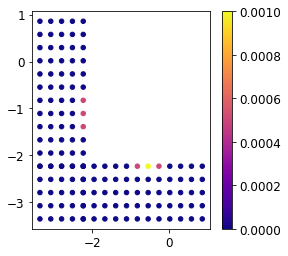

{
    'II': 1,
    'overall_cv': 0.9998066262314098,
    'n_tiles': 388,
    'n_refine': 28,
    'n_more_sims': 3,
    'grid_cost': '0.0224',
    'sim_cost': '0.0045'
}

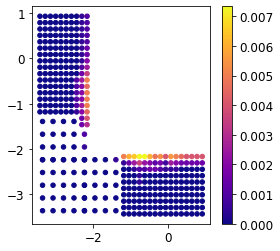

{
    'II': 2,
    'overall_cv': 0.9992453226802468,
    'n_tiles': 424,
    'n_refine': 68,
    'n_more_sims': 5,
    'grid_cost': '0.0352',
    'sim_cost': '0.0040'
}

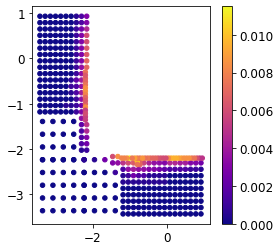

{
    'II': 3,
    'overall_cv': 0.9991317113625084,
    'n_tiles': 606,
    'n_refine': 84,
    'n_more_sims': 5,
    'grid_cost': '0.0290',
    'sim_cost': '0.0032'
}

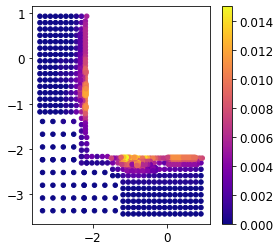

{
    'II': 4,
    'overall_cv': 0.9991317113625084,
    'n_tiles': 816,
    'n_refine': 29,
    'n_more_sims': 2,
    'grid_cost': '0.0071',
    'sim_cost': '0.0054'
}

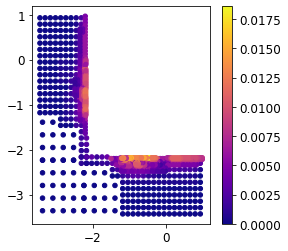

{
    'II': 5,
    'overall_cv': 0.9989488995419731,
    'n_tiles': 871,
    'n_refine': 227,
    'n_more_sims': 51,
    'grid_cost': '0.0130',
    'sim_cost': '0.0051'
}

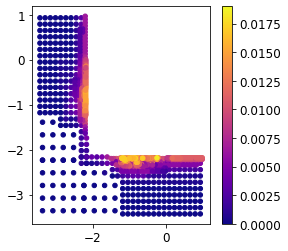

{
    'II': 6,
    'overall_cv': 0.998737936723288,
    'n_tiles': 1376,
    'n_refine': 413,
    'n_more_sims': 172,
    'grid_cost': '0.0035',
    'sim_cost': '0.0066'
}

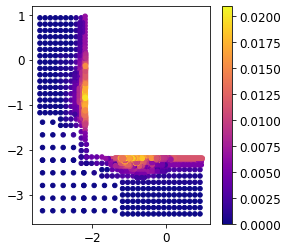

{
    'II': 7,
    'overall_cv': 0.9989488995419731,
    'n_tiles': 2371,
    'n_refine': 114,
    'n_more_sims': 58,
    'grid_cost': '0.0115',
    'sim_cost': '0.0052'
}

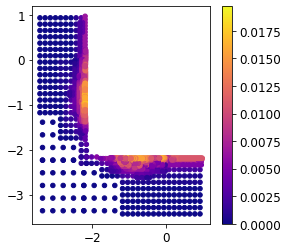

{
    'II': 8,
    'overall_cv': 0.9984348102796708,
    'n_tiles': 2655,
    'n_refine': 540,
    'n_more_sims': 352,
    'grid_cost': '0.0035',
    'sim_cost': '0.0045'
}

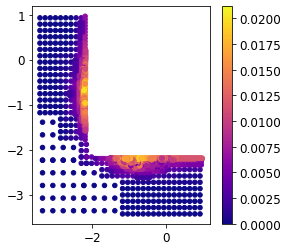

In [8]:
%matplotlib inline
iter_max = 100
init_nsims = 2000
g = grid.prune(grid.intersect_grid(g_raw, null_hypos))
target_nsims = np.full(g.n_tiles, init_nsims)
seed = 1
for II in range(iter_max):
    holderq = 6
    pointwise_target_alpha = find_pointwise_alpha_target(g, target_alpha, holderq)

    np.random.seed(seed)
    sims_unfinished = np.ones(g.n_tiles, dtype=bool)
    sim_cvs = np.empty(g.n_tiles, dtype=float)
    iters = 0
    while np.any(sims_unfinished):
        nsims = np.min(target_nsims[sims_unfinished])
        this_iter = target_nsims == nsims
        sim_cvs[this_iter] = binomial_tuning.chunked_tune(
            grid.index_grid(g, this_iter),
            simulator,
            pointwise_target_alpha[this_iter],
            nsims,
            n_arm_samples,
        )
        sims_unfinished[this_iter] = False
        iters += 1
    overall_cv = np.max(sim_cvs)

    np.random.seed(seed)
    accumulator = binomial.binomial_accumulator(
        lambda data: binomial_tuning.lookup(test_table, data[..., 0]) > overall_cv
    )

    sims_unfinished = np.ones(g.n_tiles, dtype=bool)
    typeI_sum = np.empty(g.n_tiles, dtype=float)
    iter = 0
    while np.any(sims_unfinished):
        nsims = np.min(target_nsims[sims_unfinished])
        this_iter = target_nsims == nsims
        typeI_sum[this_iter], _ = execute.chunked_simulate(
            grid.index_grid(g, this_iter),
            accumulator,
            nsims,
            n_arm_samples,
            sim_chunk_size=int(1e10),
        )
        sims_unfinished[this_iter] = False
        iters += 1

    typeI_est, typeI_CI = binomial.zero_order_bound(typeI_sum, target_nsims, 0.01, 1.0)
    typeI_bound = typeI_est + typeI_CI
    hob_upper = binomial.holder_odi_bound(
        typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
    )
    sim_cost = typeI_CI
    hob_theory_cost = target_alpha - pointwise_target_alpha
    hob_empirical_cost = hob_upper - typeI_bound

    worst_tile = np.argmax(sim_cvs)
    which_refine = (hob_upper - typeI_bound > target_grid_cost) & ((hob_upper > 0.9 * target_alpha) | (sim_cvs == sim_cvs[worst_tile]))
    which_more_sims = (typeI_CI > target_sim_cost) & ((typeI_bound > 0.9 * target_alpha) | (sim_cvs == sim_cvs[worst_tile]))

    report = dict(
        II=II,
        overall_cv=overall_cv,
        n_tiles=g.n_tiles,
        n_refine=np.sum(which_refine),
        n_more_sims=np.sum(which_more_sims),
        grid_cost=f"{hob_empirical_cost[worst_tile]:.4f}",
        sim_cost=f"{sim_cost[worst_tile]:.4f}",
    )
    rprint(report)

    plt.figure(figsize=(4,4))
    plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_est, s=20)
    plt.colorbar()
    plt.show()

    if np.sum(which_refine) > 0 or np.sum(which_more_sims) > 0:
        target_nsims[which_more_sims] *= 2

        refine_tile_idxs = np.where(which_refine)[0]
        refine_gridpt_idxs = g.grid_pt_idx[refine_tile_idxs]
        new_thetas, new_radii, unrefined_grid, keep_tile_idxs = grid.refine_grid(
            g, refine_gridpt_idxs
        )
        new_grid = grid.prune(grid.build_grid(new_thetas, new_radii, g.null_hypos))
        nearest_parent_tiles = scipy.spatial.KDTree(g.theta_tiles).query(
            new_grid.theta_tiles, k=2
        )
        new_target_nsims = np.mean(target_nsims[nearest_parent_tiles[1]], axis=1).astype(int)

        g = grid.concat_grids(unrefined_grid, new_grid)
        target_nsims = np.concatenate([target_nsims[keep_tile_idxs], new_target_nsims])
    else:
        print("done!")
        break


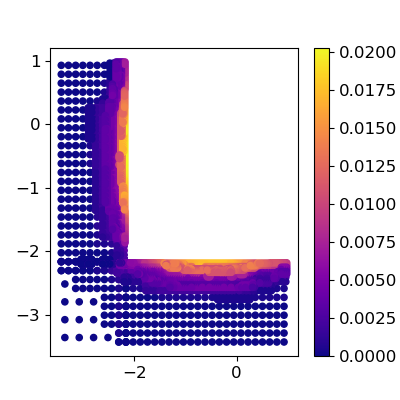

In [10]:
%matplotlib widget
plt.figure(figsize=(4,4))
plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_est, s=20)
plt.colorbar()
plt.show()
# plt.figure(figsize=(4,4))
# plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=which_more_sims, s=20)
# plt.colorbar()
# plt.show()

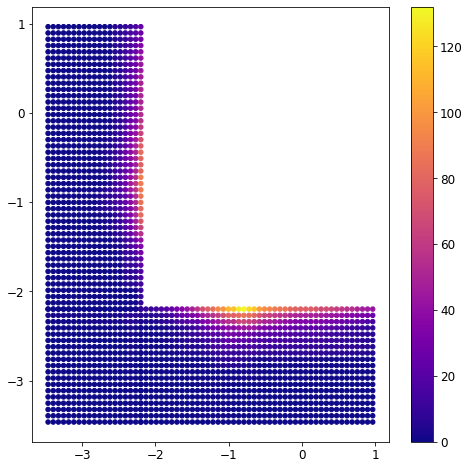

In [24]:
%matplotlib inline 
plt.figure(figsize=(8,8))
plt.scatter(g.theta_tiles[:,0], g.theta_tiles[:, 1], c=typeI_sum, s=20)
plt.colorbar()
plt.show()

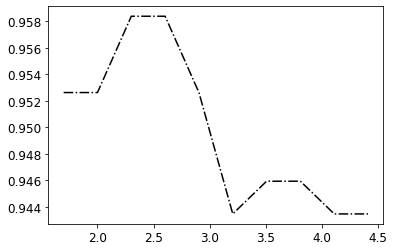

In [23]:
nsims_base = 50
cvs = []
ns = []
for i in range(10):
    nsims = nsims_base * (2 ** i)
    np.random.seed(0)
    samples = np.random.uniform(size=(nsims, n_arm_samples, n_arms))
    test_stats = simulator(g.theta_tiles, g.null_truth, samples)

    target_alpha = 0.2
    cv_idx = int(np.floor((nsims + 1) * target_alpha))
    nrejects_max = cv_idx - 1

# sorted_stats = np.sort(test_stats, axis=-1)
# sim_cv = sorted_stats[:, -cv_idx]
# np.partition lets us do this in O(n) time instead of O(n log n)
    partitioned_stats = np.partition(test_stats, nsims-cv_idx, axis=-1)
    sim_cv = partitioned_stats[:, -cv_idx]
    overall_cv = np.max(sim_cv)
    typeI_sum = np.sum(partitioned_stats[:, -cv_idx:] > overall_cv, axis=1)
    assert(np.all(typeI_sum <= nrejects_max))
    ns.append(nsims)
    cvs.append(overall_cv)
plt.plot(np.log10(ns), cvs, 'k-.')
plt.show()

In [ ]:
# uniform_samples = np.random.uniform(size=(nsims, n_arm_samples, n_arms))
# theta_tiles = g.theta_tiles
# null_truth = g.null_truth
# test_fnc = lambda data: binomial_tuning.lookup(test_table, data[...,0])

# max_sim_size, n_arm_samples, n_arms = uniform_samples.shape
# n_tiles = pointwise_alpha.shape[0]

# p_tiles = jax.scipy.special.expit(theta_tiles)
# y = jnp.sum(uniform_samples[None] < p_tiles[:, None, None, :], axis=2)
# y_flat = y.reshape((-1, n_arms))
# n_flat = jnp.full_like(y_flat, n_arm_samples)
# data = jnp.stack((y_flat, n_flat), axis=-1)
# test_stat = test_fnc(data).reshape(y.shape)

# max_null_test = jnp.max(
#     jnp.where(
#         null_truth[:, None],
#         test_stat,
#         np.min(test_stat, axis=-1, keepdims=True),
#     ),
#     axis=-1,
# )

# temp_sim_size = nsims
# cv_idx = jnp.floor((temp_sim_size + 1) * pointwise_alpha).astype(int)
# nrejects_max = cv_idx - 1
# partitioned_stats = np.partition(
#     max_null_test[:, :temp_sim_size], temp_sim_size - cv_idx, axis=-1
# )
# sim_cvs = partitioned_stats[np.arange(n_tiles), -cv_idx]

# t1s = np.sum(max_null_test[:, :] > sim_cvs[:, None], axis=1)
# half_nsims = nsims // 2
# half_t1s = np.sum(max_null_test[:, :half_nsims] > sim_cvs[:, None], axis=1)
# err = np.abs(half_t1s - (t1s / 2))
# pct_err = err / half_t1s
# pct_err
# np.random.seed(seed)
# sim_cvs = binomial_tuning.chunked_tune(g, simulator, pointwise_alpha, [nsims // 2, nsims], n_arm_samples)
# overall_cv = np.max(sim_cvs[-1])
# overall_cv